# PRMT-1984 [HYPOTHESIS] The spread of EMIS-EMIS pending (without error) transfers is even

NB: Could this be extended to Integrated Late??

### Hypothesis
We believe that EMIS-EMIS pending transfers are spread evenly across practices
We will know this to be true when we see in the data that for these transfers, they are consistently spread cross the majority of practices rather than clustered in a smaller group of practices

 

### Subsequent questions (later hypotheses)

If transfers are in a cluster of smaller practices, what do the integrations look like for those practices? I.e. are they bad at integration and therefore makes sense that they have poor pending?

In [25]:
import pandas as pd
import numpy as np

In [26]:
transfer_file_location = "s3://prm-gp2gp-data-sandbox-dev/transfers-duplicates-hypothesis/"
transfer_files = [
    "9-2020-transfers.parquet",
    "10-2020-transfers.parquet",
    "11-2020-transfers.parquet",
    "12-2020-transfers.parquet",
    "1-2021-transfers.parquet",
    "2-2021-transfers.parquet"
]
transfer_input_files = [transfer_file_location + f for f in transfer_files]
transfers_raw = pd.concat((
    pd.read_parquet(f)
    for f in transfer_input_files
))
# This is only needed when using transfers-duplicates-hypothesis datasets
transfers_raw = transfers_raw.drop(["sending_supplier", "requesting_supplier"], axis=1)

In [27]:
asid_lookup_file = "s3://prm-gp2gp-data-sandbox-dev/asid-lookup/asidLookup-Mar-2021.csv.gz"
asid_lookup = pd.read_csv(asid_lookup_file)

In [28]:
asid_lookup.loc[asid_lookup['ASID']=='260198413015']

,ASID,NACS,OrgName,MName,PName,OrgType,PostCode
28125,260198413015,G82074,BEARSTED,EGTON MEDICAL INFORMATION SYSTEMS LTD (EMIS),EMIS Web,GP Practice,ME14 4DS


In [29]:
# Given the findings in PRMT-1742 - many duplicate EHR errors are misclassified, the below reclassifies the relevant data
successful_transfers_bool = transfers_raw['request_completed_ack_codes'].apply(lambda x: True in [(np.isnan(i) or i==15) for i in x])
transfers = transfers_raw.copy()
transfers.loc[successful_transfers_bool, "status"] = "INTEGRATED"

In [30]:
pending_sender_error_codes=[6,7,10,24,30,23,14,99]
transfers_with_pending_sender_code_bool=transfers['sender_error_code'].isin(pending_sender_error_codes)
transfers_with_pending_with_error_bool=transfers['status']=='PENDING_WITH_ERROR'
transfers_which_need_pending_to_failure_change_bool=transfers_with_pending_sender_code_bool & transfers_with_pending_with_error_bool
transfers.loc[transfers_which_need_pending_to_failure_change_bool,'status']='FAILED'

In [31]:
eight_days_in_seconds=8*24*60*60
transfers_after_sla_bool=transfers['sla_duration']>eight_days_in_seconds
transfers_with_integrated_bool=transfers['status']=='INTEGRATED'
transfers_integrated_late_bool=transfers_after_sla_bool & transfers_with_integrated_bool
transfers.loc[transfers_integrated_late_bool,'status']='INTEGRATED LATE'

In [32]:
# Supplier name mapping
supplier_renaming = {
    "EGTON MEDICAL INFORMATION SYSTEMS LTD (EMIS)":"EMIS",
    "IN PRACTICE SYSTEMS LTD":"Vision",
    "MICROTEST LTD":"Microtest",
    "THE PHOENIX PARTNERSHIP":"TPP",
    None: "Unknown"
}

lookup = asid_lookup[["ASID", "MName", "NACS"]]

transfers = transfers.merge(lookup, left_on='requesting_practice_asid',right_on='ASID',how='left').drop("NACS", axis=1)
transfers = transfers.rename({'MName': 'requesting_supplier', 'ASID': 'requesting_supplier_asid'}, axis=1)
transfers = transfers.merge(lookup, left_on='sending_practice_asid',right_on='ASID',how='left')
transfers = transfers.rename({'MName': 'sending_supplier', 'ASID': 'sending_supplier_asid', 'NACS': 'sending_ods_code'}, axis=1)

transfers["sending_supplier"] = transfers["sending_supplier"].replace(supplier_renaming.keys(), supplier_renaming.values())
transfers["requesting_supplier"] = transfers["requesting_supplier"].replace(supplier_renaming.keys(), supplier_renaming.values())

### Select just relevant data: EMIS-EMIS

In [33]:
both_suppliers_EMIS_bool=(transfers['requesting_supplier']=='EMIS') & (transfers['sending_supplier']=='EMIS')

relevant_transfers=transfers.loc[both_suppliers_EMIS_bool]

### Pivot table of practice vs status volumes

In [34]:
practice_status_table=pd.pivot_table(relevant_transfers,index='requesting_practice_asid',columns='status',values='conversation_id',aggfunc='count').fillna(0)
practice_status_table['TOTAL']=practice_status_table.sum(axis=1)
practice_status_pc=100*practice_status_table.div(practice_status_table['TOTAL'],axis=0).drop('TOTAL',axis=1)
practice_status_pc.columns=practice_status_pc.columns + " %"
practice_status_pc=practice_status_pc.round(2)
practice_status_table=pd.concat([practice_status_table,practice_status_pc],axis=1)

0.1     0.00
0.2     0.00
0.3     0.00
0.4     0.00
0.5     0.20
0.6     0.48
0.7     0.74
0.8     1.12
0.9     2.27
1.0    96.25
Name: PENDING %, dtype: float64

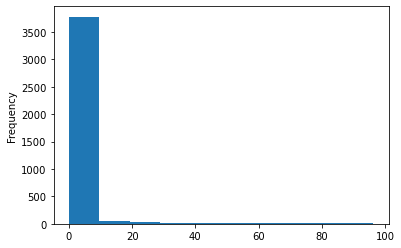

In [35]:
practice_status_table['PENDING %'].plot.hist()
practice_status_table['PENDING %'].quantile(np.arange(0.1, 1.1, 0.1))

<AxesSubplot:xlabel='TOTAL', ylabel='PENDING %'>

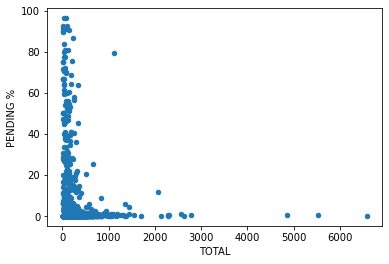

In [36]:
practice_status_table.plot.scatter(x='TOTAL',y='PENDING %')

<AxesSubplot:xlabel='TOTAL', ylabel='PENDING %'>

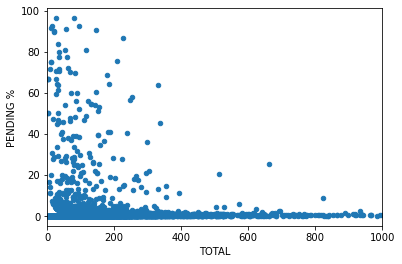

In [37]:
practice_status_table.plot.scatter(x='TOTAL',y='PENDING %',xlim=[0,1000])

<AxesSubplot:xlabel='PENDING %', ylabel='INTEGRATED LATE %'>

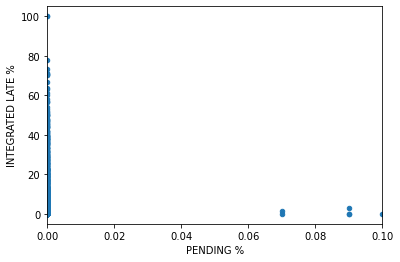

In [38]:
practice_status_table.plot.scatter(x='PENDING %',y='INTEGRATED LATE %',xlim=[0,0.1])

In [39]:
practice_status_table[["FAILED %","INTEGRATED %","INTEGRATED LATE %","PENDING %","PENDING_WITH_ERROR %"]].corr()

status,FAILED %,INTEGRATED %,INTEGRATED LATE %,PENDING %,PENDING_WITH_ERROR %
status,,,,,
FAILED %,1.000000,-0.408119,0.089799,0.380034,-0.000536
INTEGRATED %,-0.408119,1.000000,-0.813561,-0.703805,-0.089265
INTEGRATED LATE %,0.089799,-0.813561,1.000000,0.193204,-0.006839
PENDING %,0.380034,-0.703805,0.193204,1.000000,0.006568
PENDING_WITH_ERROR %,-0.000536,-0.089265,-0.006839,0.006568,1.000000


<AxesSubplot:xlabel='PENDING %', ylabel='FAILED %'>

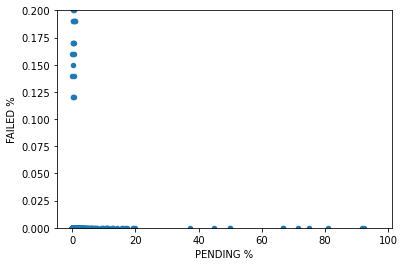

In [40]:
practice_status_table.plot.scatter(x='PENDING %',y='FAILED %',ylim=[0,0.2])

<AxesSubplot:xlabel='TOTAL', ylabel='PENDING'>

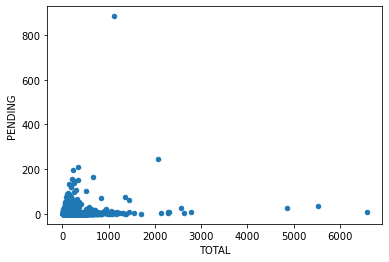

In [41]:
practice_status_table.plot.scatter(x='TOTAL',y='PENDING')

In [42]:
practice_status_table.corr()

status,FAILED,INTEGRATED,INTEGRATED LATE,PENDING,PENDING_WITH_ERROR,TOTAL,FAILED %,INTEGRATED %,INTEGRATED LATE %,PENDING %,PENDING_WITH_ERROR %
status,,,,,,,,,,,
FAILED,1.000000,0.312707,0.588573,0.401717,0.298665,0.486602,0.320491,-0.167851,0.062881,0.148647,-0.006570
INTEGRATED,0.312707,1.000000,0.131090,0.010344,0.598428,0.960091,-0.059742,0.201421,-0.177381,-0.129496,-0.019844
INTEGRATED LATE,0.588573,0.131090,1.000000,0.144810,0.256682,0.390589,0.038377,-0.274920,0.356693,0.037302,-0.003546
PENDING,0.401717,0.010344,0.144810,1.000000,0.057123,0.128827,0.203898,-0.377903,0.117084,0.519146,0.000561
PENDING_WITH_ERROR,0.298665,0.598428,0.256682,0.057123,1.000000,0.626996,-0.011583,0.026044,-0.035602,-0.030775,0.180588
TOTAL,0.486602,0.960091,0.390589,0.128827,0.626996,1.000000,-0.022222,0.085753,-0.065702,-0.067801,-0.018511
FAILED %,0.320491,-0.059742,0.038377,0.203898,-0.011583,-0.022222,1.000000,-0.408119,0.089799,0.380034,-0.000536
INTEGRATED %,-0.167851,0.201421,-0.274920,-0.377903,0.026044,0.085753,-0.408119,1.000000,-0.813561,-0.703805,-0.089265
INTEGRATED LATE %,0.062881,-0.177381,0.356693,0.117084,-0.035602,-0.065702,0.089799,-0.813561,1.000000,0.193204,-0.006839


In [43]:
practice_status_table['PENDING'].max()/practice_status_table['PENDING'].sum()

0.0748771810943588

In [44]:
practice_status_table=practice_status_table.sort_values(by='PENDING',ascending=False)
full_practice_status_table=asid_lookup.merge(practice_status_table, left_on='ASID', right_index=True, how='right')
full_practice_status_table=full_practice_status_table.drop(['MName','PName'],axis=1)
full_practice_status_table.head()


,ASID,NACS,OrgName,OrgType,PostCode,FAILED,INTEGRATED,INTEGRATED LATE,PENDING,PENDING_WITH_ERROR,TOTAL,FAILED %,INTEGRATED %,INTEGRATED LATE %,PENDING %,PENDING_WITH_ERROR %
33038,615075629043,D82088,UEA MEDICAL CENTRE,GP Practice,NR4 7TJ,123.0,36.0,73.0,884.0,1.0,1117.0,11.01,3.22,6.54,79.14,0.09
33754,669024222046,P81002,LANCASTER MEDICAL PRACTICE,GP Practice,LA1 1PN,47.0,755.0,1013.0,244.0,1.0,2060.0,2.28,36.65,49.17,11.84,0.05
28125,260198413015,G82074,BEARSTED,GP Practice,ME14 4DS,44.0,73.0,2.0,211.0,0.0,330.0,13.33,22.12,0.61,63.94,0.00
31980,540917834041,K81638,BURMA HILL PRACTICE,GP Practice,RG40 1PH,26.0,1.0,2.0,197.0,1.0,227.0,11.45,0.44,0.88,86.78,0.44
36076,847520267018,G85023,LEWISHAM MEDICAL CENTRE,GP Practice,SE13 5PJ,9.0,487.0,0.0,166.0,0.0,662.0,1.36,73.56,0.00,25.08,0.00


In [49]:
def generate_gp_table(gp_asid): 
    gp_practice_transfers=transfers.loc[transfers['requesting_practice_asid']==gp_asid].copy()
    gp_practice_transfers.loc[:,'Month']=gp_practice_transfers['date_requested'].copy().dt.to_period('M')

    gp_totals=pd.pivot_table(gp_practice_transfers,index='Month',columns='status',values='conversation_id',aggfunc='count').fillna(0)
    gp_percentages=pd.pivot_table(gp_practice_transfers,index='Month',columns='status',values='conversation_id',aggfunc='count').fillna(0).div(gp_practice_transfers['Month'].value_counts(),axis=0)
    gp_percentages=(100*gp_percentages).round(2)
    gp_percentages.columns='% '+gp_percentages.columns

    return pd.concat([gp_totals, gp_percentages], axis=1)



In [53]:
practice_status_table

status,FAILED,INTEGRATED,INTEGRATED LATE,PENDING,PENDING_WITH_ERROR,TOTAL,FAILED %,INTEGRATED %,INTEGRATED LATE %,PENDING %,PENDING_WITH_ERROR %
requesting_practice_asid,,,,,,,,,,,
615075629043,123.0,36.0,73.0,884.0,1.0,1117.0,11.01,3.22,6.54,79.14,0.09
669024222046,47.0,755.0,1013.0,244.0,1.0,2060.0,2.28,36.65,49.17,11.84,0.05
260198413015,44.0,73.0,2.0,211.0,0.0,330.0,13.33,22.12,0.61,63.94,0.00
540917834041,26.0,1.0,2.0,197.0,1.0,227.0,11.45,0.44,0.88,86.78,0.44
847520267018,9.0,487.0,0.0,166.0,0.0,662.0,1.36,73.56,0.00,25.08,0.00
...,...,...,...,...,...,...,...,...,...,...,...
324916263043,2.0,137.0,3.0,0.0,1.0,143.0,1.40,95.80,2.10,0.00,0.70
325712741017,1.0,225.0,0.0,0.0,1.0,227.0,0.44,99.12,0.00,0.00,0.44
327267571047,2.0,60.0,0.0,0.0,0.0,62.0,3.23,96.77,0.00,0.00,0.00


# Break down by user profile: 

## Ie is the issue related to a handful of practices or distributed?

Consider for each practice, it's total number of transfers, it's outcomes 

- Rank practices by the total number of issues (eg Pending)
- Break into quantiles based on number of issues
- Identify what % of users and what % of total transfers each quantile represents

In [50]:
practice_profile_data=practice_status_table.copy()

cumulative_percentage=practice_status_table['PENDING'].cumsum()/practice_status_table['PENDING'].sum()
quantiles=5
practice_profile_data['Quantile Group']=np.ceil(cumulative_percentage*quantiles)

practice_profile_data=practice_profile_data.groupby('Quantile Group').agg({'PENDING':'sum','TOTAL':'sum','INTEGRATED':'count'}).astype(int)
practice_profile_data=practice_profile_data.rename({'PENDING':'Total Pending','TOTAL':'Total Transfers','INTEGRATED':'Total Practices'},axis=1)

practice_profile_data_percentages=(100*practice_profile_data/practice_profile_data.sum()).round(2)
practice_profile_data_percentages.columns= "% " + practice_profile_data_percentages.columns

practice_profile_table=pd.concat([practice_profile_data,practice_profile_data_percentages],axis=1)
practice_profile_table

,Total Pending,Total Transfers,Total Practices,% Total Pending,% Total Transfers,% Total Practices
Quantile Group,,,,,,
1.0,2297,5440,9,19.46,0.69,0.23
2.0,2423,8655,31,20.52,1.10,0.78
3.0,2363,24489,72,20.02,3.11,1.82
4.0,2359,125857,336,19.98,15.97,8.50
5.0,2364,623578,3507,20.02,79.13,88.67


# Output to Excel

In [51]:
writer = pd.ExcelWriter('prmt-1984-emis-emis-practice-level-statuses.xlsx', engine='xlsxwriter')

practice_profile_table.to_excel(writer, sheet_name='Breakdown')
full_practice_status_table.to_excel(writer, sheet_name='Overview')

asid_of_interest=full_practice_status_table.head(10)['ASID'].values
[generate_gp_table(gp_asid).to_excel(writer,sheet_name=gp_asid) for gp_asid in asid_of_interest] 

writer.save()